In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nercsv/ner.csv


In [2]:
import numpy as np 
import pandas as pd 
import torch
from torch import nn
from torch.utils.data import Dataset,DataLoader
from torch.optim import SGD,AdamW
from transformers import BertTokenizerFast
from transformers import BertForTokenClassification
from matplotlib import pyplot as plt
from tqdm import tqdm

tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
df = pd.read_csv("/kaggle/input/nercsv/ner.csv")
df.head()

#Removing examples where the length of BIO Tags != number of tokens
l1 = len(df)
bad = []
print(f'length of the data-frame before removing examples : {len(df)}')
for i in range(len(df)):
    if len(df['text'][i].split()) != len(df['labels'][i].split()):
        bad.append(i)
        df.drop([i],axis = 0,inplace=True)

print(f'length of the data-frame after removing examples : {len(df)}')
print(f'Percentage of bad examples : {(1-len(df)/l1)*100}')
print(f'Bad Indices : {bad}')

#FINDING ALL UNIQUE LABELS
labels = [i.split() for i in df['labels'].values.tolist()]
unique_labels = set()
for lb in labels:
    [unique_labels.add(i) for i in lb if i not in unique_labels]

label2id = {val:key for key,val in enumerate(list(unique_labels))}
id2label = {key:val for key,val in enumerate(list(unique_labels))}

length of the data-frame before removing examples : 47959
length of the data-frame after removing examples : 47946
Percentage of bad examples : 0.027106486790795525
Bad Indices : [61, 10910, 21088, 23806, 26284, 26911, 26915, 32547, 37047, 41316, 45404, 46108, 47026]


In [4]:
#CLASS FOR CONSTRUCTING DATASETS FOR BERT
class DataForBert(Dataset):

    def __init__(self,df,n_tokens = 20,maxl= 256):

        self.tokenized = []
        self.labels = []
        maxl = maxl-n_tokens
        for txt,lab in zip(df['text'],df['labels']):
            toks = tokenizer(txt,add_special_tokens =False,padding = 'max_length',max_length=maxl)
            toks['input_ids'] = torch.cat((torch.full((1,n_tokens), 500).resize(n_tokens),torch.tensor(toks['input_ids'], dtype=torch.long)))
            toks['input_ids'] = toks['input_ids'].reshape((1,toks['input_ids'].shape[0]))
            
            toks['attention_mask'] = torch.cat((torch.full((1,n_tokens), 1).resize(n_tokens),torch.tensor(toks['attention_mask'], dtype=torch.long)))
            toks['attention_mask'] = toks['attention_mask'].reshape((1,toks['attention_mask'].shape[0]))
            
            self.tokenized.append(toks)
            self.labels.append(torch.LongTensor(io_align(txt,lab,tokenizer,maxl = maxl,n_tokens = n_tokens)))
            
    def __getitem__(self, i):
        #returns input_ids,mask,labels
        return self.tokenized[i], self.labels[i]

    def __len__(self):

        return len(self.tokenized)
    
def io_align(sent,label,tokenizer,maxl=256,n_tokens = 20):
    seq = sent.split(); lab = [label2id[i] for i in label.split()]
    new_lab = []
    net = 0
    for i in range(len(seq)):
        tok = tokenizer.encode(seq[i],add_special_tokens=False)
        net+=len(tok)
        if net>maxl:
            continue
        temp = [lab[i]]*(len(tok))
        new_lab.extend(temp)
    new_lab.extend([-100]*(maxl-len(new_lab)))
    temp = [-100]*n_tokens
    temp.extend(new_lab)
    return temp
    

In [5]:
class prompt(nn.Module):

    def __init__(self,
                 wte : nn.Embedding,
                 prompt_length : int = 20,
                 rand_range : float = 0.5,
                 initialize_from_vocab : bool = True):

        super(prompt, self).__init__()
        self.wte = wte
        self.prompt_length = prompt_length
        self.learned_embedding = nn.Parameter(self.initialize_embedding(wte,
                                                                        prompt_length,
                                                                        rand_range,
                                                                        initialize_from_vocab))

    
    def initialize_embedding(self,
                             wte : nn.Embedding,
                             prompt_length : int =10,
                             random_range : float = 0.5,
                             initialize_from_vocab : bool = True):

        if initialize_from_vocab:
            return self.wte.weight[:prompt_length].clone().detach()

        return torch.FloatTensor(wte.weight.size(1),prompt_length).uniform_(-random_range,random_range)

    def forward(self,tokens):
        input_embedding = self.wte(tokens[:,self.prompt_length:])
        learned_embedding = self.learned_embedding.repeat(input_embedding.size(0),1,1)
        return torch.cat((learned_embedding,input_embedding),dim=1)
                    

In [6]:
class BertModel(torch.nn.Module):

    def __init__(self,
                 prompt_length = 20,
                 initialize_from_vocab = True
                 ):

        super(BertModel, self).__init__()

        self.bert = BertForTokenClassification.from_pretrained('bert-base-cased', num_labels=len(unique_labels))
        self.prompt_length = prompt_length
        self.prompt = prompt(self.bert.get_input_embeddings(),
                             prompt_length = self.prompt_length,
                             initialize_from_vocab = initialize_from_vocab)
        
        self.bert.set_input_embeddings(self.prompt)

    def forward(self, input_id, mask, label):
        output = self.bert(input_ids=input_id, attention_mask=mask, labels=label, return_dict=False)
        return output

In [7]:
def train_loop(model,df_train, df_val,EPOCHS,LEARNING_RATE,BATCH_SIZE,optim = "SGD",):

    train_data = DataForBert(df_train)
    val_data = DataForBert(df_val)

    train_loader = DataLoader(train_data,  batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_data,  batch_size=BATCH_SIZE)

    if optim == "AdamW":
        optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
    elif optim == "SGD":
        optimizer = SGD(model.parameters(), lr=LEARNING_RATE)

    if DEVICE == 'cuda':
        model = model.cuda()

    epoch_data = []
    for epoch_num in range(EPOCHS):
        
        print(model.prompt.learned_embedding)

        total_acc_train = 0
        total_loss_train = 0
        
        total_acc_train_o = 0

        model.train()

        for train_in, train_out in tqdm(train_loader):
            train_out = train_out.to(DEVICE)
            mask = train_in['attention_mask'].squeeze(1).to(DEVICE)
            input_id = train_in['input_ids'].squeeze(1).to(DEVICE)

            optimizer.zero_grad()
            loss, logits = model(input_id, mask, train_out)
            
            for i in range(logits.shape[0]):

              logits_clean= logits[i][train_out[i] != -100]
              label_clean = train_out[i][train_out[i] != -100]

              predictions = logits_clean.argmax(dim=1)
              acc = (predictions == label_clean).float().mean()
              total_acc_train += acc
              total_loss_train += loss.item()
                
              logits_clean2 = logits[i][train_out[i] != -100]
              label_clean2 = train_out[i][train_out[i] != -100]
              logits_clean2 = logits_clean2[label_clean2 != label2id['O']]
              label_clean2 = label_clean2[label_clean2 != label2id['O']]

              predictions2 = logits_clean2.argmax(dim=1)
              acc2 = (predictions2 == label_clean2).float().mean()
                
              if len(predictions2)>0 and len(label_clean2)>0:
                total_acc_train_o += acc2
              
            loss.backward()
            optimizer.step()

        model.eval()

        total_acc_val = 0
        total_acc_val_o = 0
        total_loss_val = 0

        for val_in, val_out in val_loader:
            

            val_out = val_out.to(DEVICE)
            mask = val_in['attention_mask'].squeeze(1).to(DEVICE)
            input_id = val_in['input_ids'].squeeze(1).to(DEVICE)

            loss, logits = model(input_id, mask, val_out)

            for i in range(logits.shape[0]):

              logits_clean = logits[i][val_out[i] != -100]
              label_clean = val_out[i][val_out[i] != -100]

              predictions = logits_clean.argmax(dim=1)
              acc = (predictions == label_clean).float().mean()
              total_acc_val += acc
              total_loss_val += loss.item()
                
              logits_clean2 = logits[i][val_out[i] != -100]
              label_clean2 = val_out[i][val_out[i] != -100]
              logits_clean2 = logits_clean2[label_clean2 != label2id['O']]
              label_clean2 = label_clean2[label_clean2 != label2id['O']]
              
              
              predictions2 = logits_clean2.argmax(dim=1)
              acc2 = (predictions2 == label_clean2).float().mean()
              if len(predictions2)>0 and len(label_clean2)>0:
                total_acc_val_o += acc2
                
        val_accuracy = (total_acc_val / len(df_val))
        val_loss = total_loss_val / len(df_val)
        print(
            f'Epochs: {epoch_num + 1} | Loss: {total_loss_train / len(df_train): .3f} | Accuracy: {total_acc_train / len(df_train): .3f} | Val_Loss: {total_loss_val / len(df_val): .3f} | Accuracy: {total_acc_val / len(df_val): .3f}')
        print(f'Accuracy train w/o O {total_acc_train_o / len(df_train): .3f} | Accuracy val w/o O = {total_acc_val_o / len(df_val): .3f}')
        
        epoch_data.append((total_loss_train / len(df_train),total_acc_train / len(df_train),total_acc_train_o / len(df_train),total_loss_val / len(df_val),val_accuracy,total_acc_val_o / len(df_val)))
    return epoch_data,model

In [8]:
def test_pipeline(tot_examples,maxl=128,batch_size=2,epochs=5,learning_rate=1e-5,optim = "AdamW"):
    df_temp = {'text':[], 'labels':[]}
    tot = 0
    for txt,lab in zip(df['text'],df['labels']):
        l = len(tokenizer.encode(txt,add_special_tokens = False))
        if l<=maxl:
            df_temp['text'].append(txt)
            df_temp['labels'].append(lab)
        if tot>=tot_examples:
            break
        tot+=1

    df_temp = pd.DataFrame(df_temp)
    df_train, df_val, df_test = np.split(df_temp.sample(frac=1, random_state=42),
                            [int(.8 * len(df_temp)), int(.9 * len(df_temp))])
    
    model = BertModel()
    ep_data,model = train_loop(model,df_train,df_val,epochs,learning_rate,batch_size,optim= optim)
    
    train_loss,train_acc,train_acc_o,val_loss,val_acc,val_acc_o = [],[],[],[],[],[]
    
    for a,b,c,d,e,f in ep_data:
        try:
            train_loss.append(a.item())
        except:
            train_loss.append(a)
        try:
            train_acc.append(b.item())
        except:
            train_acc.append(b)
        try:
            train_acc_o.append(c.item())
        except:
            train_acc_o.append(c)
        try:
            val_loss.append(d.item())
        except:
            val_loss.append(d)
        try:
            val_acc.append(e.item())
        except:
            val_acc.append(e)
        try:
            val_acc_o.append(f.item())
        except:
            val_acc_o.append(f)
        
    print(train_loss,train_acc,train_acc_o,val_loss,val_acc,val_acc_o)
    loss_metrics = pd.DataFrame({'Train loss':train_loss,
               'Val loss':val_loss
               })
    
    acc_metrics = pd.DataFrame({'Train Accuracy':train_acc,
                                'Train Accuracy without O':train_acc_o,
                                'Val Accuracy':val_acc,
                                'Val Accuracy without O':val_acc_o})
    
    loss_metrics.plot()
    acc_metrics.plot()
    return df_test, model, (loss_metrics,acc_metrics)
        
    

In [9]:
torch.cuda.empty_cache()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

Epochs: 1 | Loss:  0.627 | Accuracy:  0.851 | Val_Loss:  0.305 | Accuracy:  0.909
Accuracy train w/o O  0.237 | Accuracy val w/o O =  0.507


100%|██████████| 100/100 [00:39<00:00,  2.50it/s]


Epochs: 2 | Loss:  0.239 | Accuracy:  0.934 | Val_Loss:  0.237 | Accuracy:  0.942
Accuracy train w/o O  0.599 | Accuracy val w/o O =  0.642


100%|██████████| 100/100 [00:39<00:00,  2.50it/s]


Epochs: 3 | Loss:  0.152 | Accuracy:  0.958 | Val_Loss:  0.236 | Accuracy:  0.946
Accuracy train w/o O  0.694 | Accuracy val w/o O =  0.662


100%|██████████| 100/100 [00:40<00:00,  2.50it/s]


Epochs: 4 | Loss:  0.107 | Accuracy:  0.971 | Val_Loss:  0.238 | Accuracy:  0.947
Accuracy train w/o O  0.743 | Accuracy val w/o O =  0.674


100%|██████████| 100/100 [00:40<00:00,  2.50it/s]


Epochs: 5 | Loss:  0.075 | Accuracy:  0.979 | Val_Loss:  0.251 | Accuracy:  0.947
Accuracy train w/o O  0.773 | Accuracy val w/o O =  0.672
[0.6274624253809452, 0.23851132072508335, 0.15163948487490417, 0.10737233007326723, 0.07468697218224406] [0.8510339856147766, 0.934264600276947, 0.9578344225883484, 0.9707465171813965, 0.978836178779602] [0.23695418238639832, 0.5989925861358643, 0.6935043334960938, 0.7429572939872742, 0.7727271318435669] [0.30525505661964414, 0.23720861256122588, 0.235792356133461, 0.2384558355808258, 0.2507458084821701] [0.9094282388687134, 0.9417303204536438, 0.9459300637245178, 0.9465174078941345, 0.9465816020965576] [0.5074818134307861, 0.6416094303131104, 0.6618524193763733, 0.673539936542511, 0.6724637746810913]




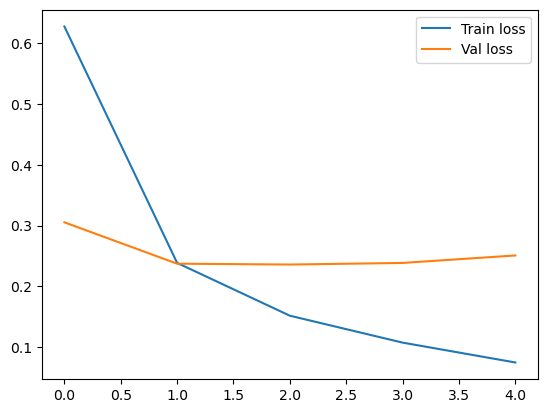

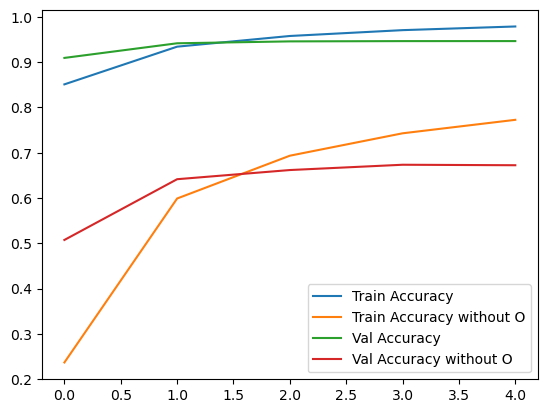

In [11]:
df_test2k_np, model2k_np, metrics2k_np = test_pipeline(2000,maxl=128,batch_size = 16,epochs = 5,learning_rate = 3e-5,optim = 'AdamW')
print()
print()


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

Parameter containing:
tensor([[-0.0005, -0.0416,  0.0131,  ..., -0.0039, -0.0335,  0.0150],
        [ 0.0169, -0.0311,  0.0042,  ..., -0.0147, -0.0356, -0.0036],
        [-0.0006, -0.0267,  0.0080,  ..., -0.0100, -0.0331, -0.0165],
        ...,
        [-0.0001, -0.0265, -0.0038,  ..., -0.0071, -0.0464, -0.0108],
        [ 0.0074, -0.0357,  0.0027,  ...,  0.0012, -0.0399, -0.0022],
        [ 0.0108, -0.0357, -0.0003,  ..., -0.0019, -0.0383, -0.0027]],
       device='cuda:0', requires_grad=True)


100%|██████████| 500/500 [03:19<00:00,  2.51it/s]


Epochs: 1 | Loss:  0.297 | Accuracy:  0.924 | Val_Loss:  0.180 | Accuracy:  0.955
Accuracy train w/o O  0.561 | Accuracy val w/o O =  0.681
Parameter containing:
tensor([[ 0.0001, -0.0410,  0.0129,  ..., -0.0034, -0.0330,  0.0154],
        [ 0.0167, -0.0320,  0.0039,  ..., -0.0150, -0.0358, -0.0032],
        [-0.0008, -0.0267,  0.0080,  ..., -0.0101, -0.0333, -0.0163],
        ...,
        [-0.0005, -0.0260, -0.0045,  ..., -0.0073, -0.0463, -0.0113],
        [ 0.0077, -0.0362,  0.0034,  ...,  0.0013, -0.0403, -0.0029],
        [ 0.0103, -0.0359, -0.0007,  ..., -0.0022, -0.0383, -0.0018]],
       device='cuda:0', requires_grad=True)


100%|██████████| 500/500 [03:19<00:00,  2.51it/s]


Epochs: 2 | Loss:  0.139 | Accuracy:  0.962 | Val_Loss:  0.163 | Accuracy:  0.955
Accuracy train w/o O  0.708 | Accuracy val w/o O =  0.684
Parameter containing:
tensor([[ 0.0001, -0.0403,  0.0129,  ..., -0.0036, -0.0329,  0.0141],
        [ 0.0168, -0.0324,  0.0038,  ..., -0.0152, -0.0358, -0.0027],
        [-0.0010, -0.0268,  0.0079,  ..., -0.0102, -0.0335, -0.0157],
        ...,
        [-0.0002, -0.0256, -0.0048,  ..., -0.0081, -0.0460, -0.0114],
        [ 0.0085, -0.0358,  0.0029,  ...,  0.0008, -0.0396, -0.0028],
        [ 0.0100, -0.0358, -0.0002,  ..., -0.0019, -0.0378, -0.0014]],
       device='cuda:0', requires_grad=True)


100%|██████████| 500/500 [03:19<00:00,  2.51it/s]


Epochs: 3 | Loss:  0.098 | Accuracy:  0.972 | Val_Loss:  0.164 | Accuracy:  0.958
Accuracy train w/o O  0.746 | Accuracy val w/o O =  0.693
Parameter containing:
tensor([[ 1.8076e-06, -4.0327e-02,  1.3335e-02,  ..., -3.2810e-03,
         -3.3565e-02,  1.4039e-02],
        [ 1.5810e-02, -3.3312e-02,  3.6092e-03,  ..., -1.5048e-02,
         -3.5373e-02, -2.9940e-03],
        [-8.3545e-04, -2.6679e-02,  7.9107e-03,  ..., -1.0031e-02,
         -3.3189e-02, -1.5406e-02],
        ...,
        [-5.3022e-04, -2.5303e-02, -4.9735e-03,  ..., -8.0452e-03,
         -4.5811e-02, -1.2361e-02],
        [ 8.2264e-03, -3.6099e-02,  2.7067e-03,  ..., -2.7746e-04,
         -3.9800e-02, -2.7132e-03],
        [ 9.8657e-03, -3.5860e-02,  5.7524e-04,  ..., -1.6293e-03,
         -3.7850e-02, -1.3862e-03]], device='cuda:0', requires_grad=True)


100%|██████████| 500/500 [03:19<00:00,  2.51it/s]


Epochs: 4 | Loss:  0.070 | Accuracy:  0.979 | Val_Loss:  0.181 | Accuracy:  0.958
Accuracy train w/o O  0.771 | Accuracy val w/o O =  0.703
Parameter containing:
tensor([[ 0.0006, -0.0403,  0.0136,  ..., -0.0028, -0.0330,  0.0142],
        [ 0.0158, -0.0337,  0.0033,  ..., -0.0156, -0.0359, -0.0035],
        [-0.0011, -0.0265,  0.0077,  ..., -0.0101, -0.0331, -0.0154],
        ...,
        [-0.0010, -0.0259, -0.0052,  ..., -0.0088, -0.0454, -0.0132],
        [ 0.0079, -0.0362,  0.0017,  ..., -0.0012, -0.0407, -0.0033],
        [ 0.0091, -0.0352, -0.0008,  ..., -0.0028, -0.0374, -0.0022]],
       device='cuda:0', requires_grad=True)


100%|██████████| 500/500 [03:19<00:00,  2.51it/s]


Epochs: 5 | Loss:  0.050 | Accuracy:  0.986 | Val_Loss:  0.189 | Accuracy:  0.959
Accuracy train w/o O  0.794 | Accuracy val w/o O =  0.708
[0.29679769185185434, 0.13914628482982516, 0.09751863688230515, 0.06963338873907923, 0.05002816260047257] [0.924365222454071, 0.9618274569511414, 0.9721664786338806, 0.9794739484786987, 0.9855326414108276] [0.5610299110412598, 0.7080084681510925, 0.745829701423645, 0.7708473205566406, 0.7935227155685425] [0.17998292946815492, 0.16289053988456725, 0.1644753927588463, 0.18104866242408751, 0.1886018642783165] [0.9547743797302246, 0.9552853107452393, 0.9579646587371826, 0.957787811756134, 0.9590321183204651] [0.6805840730667114, 0.6836920976638794, 0.6925867199897766, 0.7025495767593384, 0.7078996300697327]




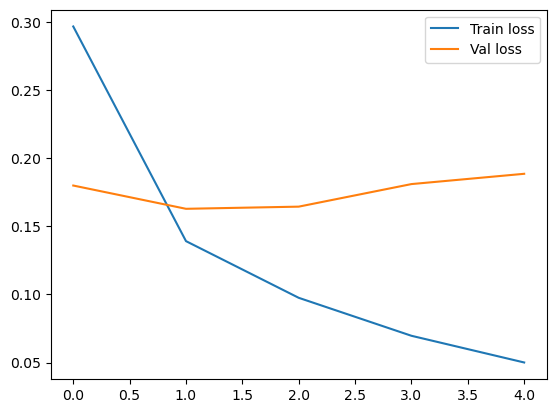

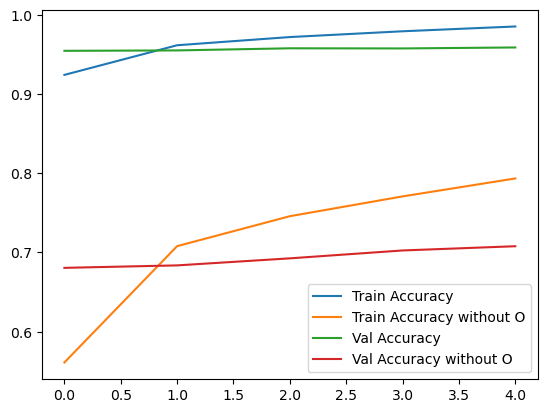

In [12]:
df_test2k_p, model2k_p, metrics2k_p = test_pipeline(10000,maxl=128,batch_size = 16,epochs = 5,learning_rate = 3e-5,optim = 'AdamW')
print()
print()


In [ ]:
df_test10k, model10k, metrics10k = test_pipeline(10000,maxl=128,batch_size = 8,epochs = 5,learning_rate = 3e-5,optim = 'AdamW')
print()
print()
test(df_test10k,model10k,print_examples = 5)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

Epochs: 1 | Loss:  0.267 | Accuracy:  0.931 | Val_Loss:  0.179 | Accuracy:  0.951
Accuracy train w/o O  0.582 | Accuracy val w/o O =  0.678


100%|██████████| 1000/1000 [03:36<00:00,  4.61it/s]


Epochs: 2 | Loss:  0.133 | Accuracy:  0.963 | Val_Loss:  0.161 | Accuracy:  0.956
Accuracy train w/o O  0.713 | Accuracy val w/o O =  0.690


100%|██████████| 1000/1000 [03:36<00:00,  4.61it/s]


Epochs: 3 | Loss:  0.091 | Accuracy:  0.974 | Val_Loss:  0.165 | Accuracy:  0.958
Accuracy train w/o O  0.753 | Accuracy val w/o O =  0.703


 25%|██▍       | 246/1000 [00:53<02:43,  4.61it/s]

In [ ]:
df_test20k, model20k, metrics20k = test_pipeline(20000,maxl=128,batch_size = 8,epochs = 5,learning_rate = 3e-5,optim = 'AdamW')
print()
print()
test(df_test20k,model20k,print_examples = 5)

In [15]:
import numpy as np
def test(df_test,model,print_examples = 10,batch_size = 4):
    
    model.eval()
    test_data = DataForBert(df_test)
    test_loader = DataLoader(test_data,  batch_size=batch_size, shuffle=True)
    
    total_acc = 0
    total_acc_o = 0
    
    printed = 0
    
    for test_in, test_out in test_loader:
            test_out = test_out.to(DEVICE)
            mask = test_in['attention_mask'].squeeze(1).to(DEVICE)
            input_id = test_in['input_ids'].squeeze(1).to(DEVICE)

            loss, logits = model(input_id, mask, test_out)

            for i in range(logits.shape[0]):

              logits_clean = logits[i][test_out[i] != -100]
              label_clean = test_out[i][test_out[i] != -100]

              predictions = logits_clean.argmax(dim=1)
              acc = (predictions == label_clean).float().mean()
              total_acc += acc
                
              logits_clean2 = logits[i][test_out[i] != -100]
              label_clean2 = test_out[i][test_out[i] != -100]
              logits_clean2 = logits_clean2[label_clean2 != label2id['O']]
              label_clean2 = label_clean2[label_clean2 != label2id['O']]
              
              
              predictions2 = logits_clean2.argmax(dim=1)
              acc2 = (predictions2 == label_clean2).float().mean()
              if len(predictions2)>0 and len(label_clean2)>0:
                total_acc_o += acc2
                
              if printed <= print_examples and np.random.randint(0,2) !=0 and not acc.cpu().isnan() and acc.item() >0.8:
                print(' '.join(tokenizer.convert_ids_to_tokens(input_id[i][input_id[i] != 0])))
                print(' '.join([id2label[meow] for meow in logits[i][test_out[i] != -100].argmax(dim = 1).tolist()])," <- Predicted")
                print(' '.join([id2label[meow] for meow in test_out[i][test_out[i] != -100].tolist()])," <- Actual")
                print('Accuracy = ',acc2.cpu())
                printed+=1
                print()

In [16]:
test(df_test5k,model5k,print_examples = 5)

It was instituted in 1968 by the Bank of Sweden in memory of the founder of the Nobel Prize , Swedish philanthropist Alfred Nobel .
O O O O B-tim O O B-org I-org I-org O O O O O O O B-org I-org O B-gpe O B-per I-org O  <- Predicted
O O O O B-tim O O B-org I-org I-org O O O O O O O B-org I-org O B-gpe O B-per I-per O  <- Actual
Accuracy =  tensor(0.8889)

Based on the WHO ' s records for Asia , Cambodia has the highest percentage of people infected with HIV - at 1 . 9 percent of the population .
O O O B-org O O O O B-geo O B-geo O O O O O O O O B-org O O O O O O O O O O  <- Predicted
O O O B-org O O O O B-geo O B-geo O O O O O O O O B-org O O O O O O O O O O  <- Actual
Accuracy =  tensor(1.)

Two other provisions in the bill would create a so - called guest worker program and would de ##port illegal immigrants who have been in the country for fewer than five years .
O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O B-tim O O  <- Predicted
O O O O O O O O O O O O O O O O O O O 